# Get all the imports necessary

In [16]:
# using GuSTO
include("../src/GuSTO.jl")
using AstrobeeRobot
using Plots
using JLD2, FileIO
using Plots
import Plots.Animation

# Only Freeflyer models to be used

In [18]:
robot = Freeflyer()
model = FreeflyerSE2()

FreeflyerSE2(6, 3, 0.05, Any[], Any[], Any[])

# No obstacle environment

In [19]:
function setUpEnvironmentNoObstacle()
    env = Table(:stanford);
    return env
end

setUpEnvironmentNoObstacle (generic function with 1 method)

# Single obstacle environment

In [20]:
function setUpEnvironmentSingleObstacle(xObs = 1.500, yObs = 1.500, width = 0.27)
    env = Table(:stanford);
    centers = Vector()
    push!(centers, [xObs; yObs; 0.0])

    widths = [width; width; 0.127]
    inflation = 0.05*ones(3)

    for idx in 1:length(centers)
        push!(env.obstacle_set, HyperRectangle(Vec3f0(centers[idx]-0.5*widths-inflation+[0.;0.;0.5*widths[1]]), Vec3f0(widths+2*inflation)))
    end
    return env
end

setUpEnvironmentSingleObstacle (generic function with 4 methods)

# Multiple obstacle environment

In [21]:
function setUpEnvironment()
    env = Table(:stanford);
    centers = Vector()
    push!(centers, [0.460; 0.315; 0.0])
    push!(centers, [0.201; 1.085; 0.0])
    push!(centers, [0.540; 2.020; 0.0])
    push!(centers, [1.374; 0.196; 0.0])
    push!(centers, [1.063; 1.354; 0.0])
    push!(centers, [1.365; 2.322; 0.0])
    push!(centers, [2.221; 0.548; 0.0])
    push!(centers, [2.077; 1.443; 0.0])
    push!(centers, [3.098; 1.186; 0.0])
    push!(centers, [2.837; 2.064; 0.0])
    # push!(centers, [1.500; 1.500; 0.0])

    widths = [0.27; 0.27; 0.127]
    inflation = 0.05*ones(3)

    for idx in 1:length(centers)
        push!(env.obstacle_set, HyperRectangle(Vec3f0(centers[idx]-0.5*widths-inflation+[0.;0.;0.5*widths[1]]), Vec3f0(widths+2*inflation)))
    end
    return env
end

setUpEnvironment (generic function with 1 method)

# Create obstacle grid representation using centers, widths, and inflation
TODO

# Set up problem, initial goal and final goal

In [22]:
function setUpProblem(N, x_init, x_goal;tf_guess = 200.)
    goal_set = GoalSet()
    add_goal!(goal_set, Goal(PointGoal(x_goal), tf_guess, model))
    PD = ProblemDefinition(robot, model, env, x_init, goal_set)
    TOP = TrajectoryOptimizationProblem(PD, N, tf_guess, fixed_final_time=true)
    TOSgusto = TrajectoryOptimizationSolution(TOP)
    return TOP, TOSgusto
end


setUpProblem (generic function with 1 method)

# Create GIF of XY trajectories

In [23]:
function plotGifOfXYTrajectories(X_vec)
    n_iter = size(X_vec,1)
    anim = @animate for i=1:n_iter
        X = X_vec[i]
        plot([X[1,:]],[X[2,:]],
        xlabel = "x",
        ylabel = "y",
        legend = :none)
#         plotSingleXYTrajectory(X_vec[i])
    end
    gif(anim, "/anim_fps15.gif", fps = 15)
    
    
#     @gif for i=1:n_iter
#         plotSingleXYTrajectory(X_vec[i])
#     end every 1
end
plotXYTrajectories(traj_X_vec)


UndefVarError: UndefVarError: traj_X_vec not defined

# Plot all trajectory iterations on one plot

In [24]:
function plotXYTrajectories(X_vec)
    n_iter = size(X_vec,1)
    gr(fmt=:png)
    plot()
    for i=1:n_iter
        X = X_vec[i]
        if i==1
            scatter!([X[1,1]],[X[2,1]],label="start point", marker=8)
            scatter!([X[1,end]],[X[2,end]],label="goal point", marker=8)
        end
        
        plot!([X[1,:]],[X[2,:]],
        xlabel = "x",
        ylabel = "y",
        label = "iteration $i")
    end
    plot!()
end


plotXYTrajectories (generic function with 1 method)

# Plot all velocity trajectories on one plot

In [25]:
function plotVelocities(X_vec)
    n_iter = size(X_vec,1)
    gr(fmt=:png)
    plot()
    for i=1:n_iter
        X = X_vec[i]
        N = size(X,2)
        plot!([collect(1:N)],[sqrt.(X[4,:].^2 + X[5,:].^2)],
        xlabel = "t",
        ylabel = "v",
        label = "iteration $i")
    end
    plot!()
end


plotVelocities (generic function with 1 method)

# Plot single XY trajectory

In [26]:
function plotSingleXYTrajectory(X)
    gr(fmt=:png)
    plot()
    plot!([X[1,:]],[X[2,:]],
        xlabel = "x",
        ylabel = "y",
        legend = :none)
    plot!()
end

plotSingleXYTrajectory (generic function with 1 method)

# Plot velocity along a trajectory

In [27]:
function plotVelocity(X, N)
    gr(fmt=:png)
    plot()
    plot!([collect(1:N)],[sqrt.(X[4,:].^2 + X[5,:].^2)],
        xlabel = "t",
        ylabel = "v",
        legend = :none)
    plot!()
end

plotVelocity (generic function with 1 method)

# Code for animating free-flyer trajectories

In [28]:
function visualizeTraj(env, TOSgusto)
    vis = Visualizer()
    delete!(vis)

    vis[:goal]
    setobject!(vis[:goal][:goal], 
        Object(HyperSphere(Point3(x_goal[1:2]..., robot.r), 0.1),
            MeshBasicMaterial(color=RGBA(0,1.0,0.,0.3))))

    vis[:table]
    table_dim = env.worldAABBmax-env.worldAABBmin
    setobject!(vis[:table][:table], 
            Object(HyperRectangle(env.worldAABBmin..., table_dim...),
                MeshBasicMaterial(color=RGBA(0,1.0,0.,0.3))))

    vis[:obstacles]
    for (idx,obs) in enumerate(env.obstacle_set)
        setobject!(vis[:obstacles][Symbol(string("obs",idx))], 
            Object(obs,MeshBasicMaterial(color=RGBA(1.0,0.,0.,0.3))))
    end

    vis[:robot]

    setobject!(vis[:robot][:base],
        Object(Cylinder(Point3f0(0,0,0.),Point3f0(0.,0.,0.5),Float32(robot.r)),MeshBasicMaterial(color=RGBA(0,0.,1.,0.7))))

    up = [0;0;1.]
    q0 = vec2quat(up,x_init[3])
    Qs = Vector{Vector{Float64}}()

    speed_factor = 10

    for k in 1:speed_factor:N
        q = [quat_inv(quat_multiply(mrp2quat([0.; 0.; tan(TOSgusto.SCPS.traj.X[3,k]/4)]), q0)); [TOSgusto.SCPS.traj.X[1:2,k]; robot.r]]
        push!(Qs,q)
    end

    anim = MeshCat.Animation()
    for k in 1:N
        atframe(anim, vis, 5*k) do frame
            settransform!(frame[:robot], Translation(TOSgusto.traj.X[1,k], 
                TOSgusto.traj.X[2,k], TOSgusto.traj.X[3,k]))
        end
    end
    setanimation!(vis, anim)

    # plot_in_cell = true
    plot_in_cell = false
    plot_in_cell ? IJuliaCell(vis) : open(vis)
end

visualizeTraj (generic function with 1 method)

# Create Training data from X,U trajectories and trust region values

In [38]:
function createTrainingInputAndOutput(traj_X_vec, traj_U_vec, ω_vec, Δ_vec)
    X_row = hcat((map(a -> a[:], traj_X_vec))...)'
    U_row = hcat((map(a -> a[:], traj_U_vec))...)'
    
#     @show(size(ω_vec))
#     @show(size(X_row))
    train_input = hcat(X_row, U_row, ω_vec, Δ_vec)[1:end-1,:]

    diff_X = traj_X_vec[2:end]-traj_X_vec[1:end-1]
    diff_U = traj_U_vec[2:end]-traj_U_vec[1:end-1]
    diff_X_row = hcat((map(a -> a[:], diff_X))...)'
    diff_U_row = hcat((map(a -> a[:], diff_U))...)'

    train_output = hcat(diff_X_row, diff_U_row)
    
    if size(train_input,1) != size(train_output,1)
        println("ERROR: train input and output have different # of rows")
    end
    if size(train_input,2) - 2 != size(train_output,2)
        println("ERROR: each row of train input should 2 elements more than output")
    end
    
    return train_input, train_output
    
end

createTrainingInputAndOutput (generic function with 1 method)

# Verify training input and output creation


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

size(traj_X_vec) = (2,)
size(traj_X_vec[1]) = (6, 20)


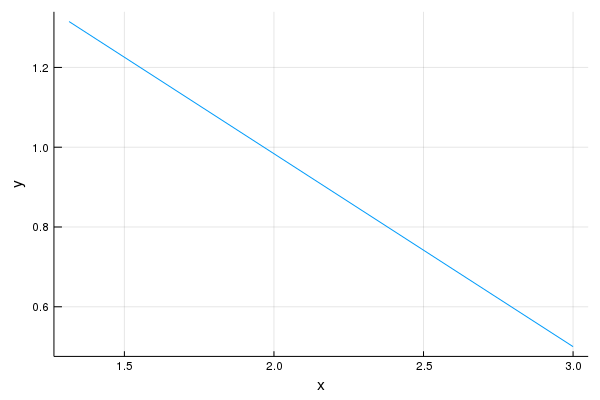

In [30]:
env = setUpEnvironmentSingleObstacle()
xObs = env.obstacle_set[1].origin[1]
yObs = env.obstacle_set[1].origin[2]
N = 20
x_init = [xObs; yObs; 0; 0; 0; 0] # starting inside the obstacle- infeasible
x_goal = [3.; 0.5; 0; 0; 0; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess=80);
traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]
# Solve one step at a time with IPOPT
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
@show size(traj_X_vec)
@show size(traj_X_vec[1])
one_X_traj = traj_X_vec[1]
gr(fmt=:png)
plot()
plot!([one_X_traj[1,:]],[one_X_traj[2,:]],
    xlabel = "x",
    ylabel = "y",
    legend = :none)
plot!()


# train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
# @show size(train_input)
# xvals = train_input[1,1:20]
# @show size(xvals)
# yvals = train_input[1,21:40]
# @show size(yvals)
# gr(fmt=:png)
# plot()
# plot!([xvals],[yvals],
#     xlabel = "x",
#     ylabel = "y",
#     legend = :none)
# plot!()

# Recover goal and start points from training data

In [31]:
function recoverProblemConditionsFromTrainInput(train_input) 
    recover_x_init_from_train = train_input[1,1:6]
    @show recover_x_init_from_train
    recover_x_goal_from_train = train_input[1,(6*N-5):(6*N + 1)]
    @show recover_x_goal_from_train
    # NOTE that size(train_input,2)-2 = x_dim * N
end
function recoverProblemConditionsFromTrajVec(traj_X_vec) 
    recover_x_init = traj_X_vec[1][:,1]
    @show recover_x_init
    recover_x_goal = traj_X_vec[1][:,end]
    @show recover_x_goal
    # NOTE that size(traj_X_vec[1]) = (x_dim * N)
end

recoverProblemConditionsFromTrajVec (generic function with 1 method)

# Plot trajectory if starting from within obstacle (infeasible start point)

In [22]:
env = setUpEnvironmentSingleObstacle()
xObs = env.obstacle_set[1].origin[1]
yObs = env.obstacle_set[1].origin[2]
N = 20
x_init = [xObs; yObs; 0; 0; 0; 0] # starting inside the obstacle- infeasible
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess=200);
traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]
# Solve one step at a time with IPOPT
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.solver_status
@show TOSgusto.SCPS.accept_solution
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.converged
iterCount = 1
max_iter = 30
while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
    solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#             @show TOSgusto.SCPS.scp_status
#             @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
    if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = iterCount + 1
        @show iterCount
    end
end
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.solver_status
@show TOSgusto.SCPS.accept_solution
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.converged
# Conclusion: if the scp_status never changes to OK, we probably shouldn't store this set of trajectories
# This basically means that GuSTO converged (SCPS.converged) and is "locally solved" (SCPS.solver_status) but never finds an "OK" solution (SCPS.scp_status)

(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED]
(TOSgusto.SCPS).accept_solution = Bool[true, true]
(((TOSgusto.SCPS).param).alg).ω_vec = [1.0, 10.0]
(TOSgusto.SCPS).converged = false
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
(TOSgusto.SCPS).accept_solution = Bool[true, true, true, true, true, true]
(((TOSgusto.SCPS).param).alg).ω_vec = [1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
(TOSgusto.SCPS).converged = true


true

# Plot trajectories from GuSTO for no obstacles

## tf = 200 s

In [15]:
env = setUpEnvironmentNoObstacle()
N = 20
x_init = [0.2; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess=200);
traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]
# Solve one step at a time with IPOPT
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
iterCount = 1
max_iter = 30
while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
    solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#             @show TOSgusto.SCPS.scp_status
#             @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
    if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = iterCount + 1
        @show iterCount
    end
end


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

iterCount = 2
iterCount = 3
iterCount = 4


(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :OK, :OK, :OK]


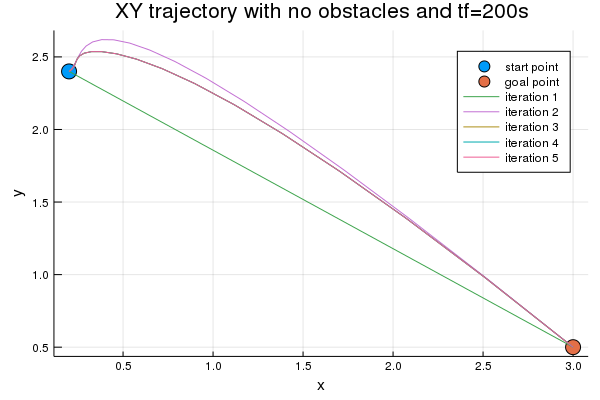

In [16]:
@show TOSgusto.SCPS.scp_status
plotXYTrajectories(traj_X_vec)
title!("XY trajectory with no obstacles and tf=200s")


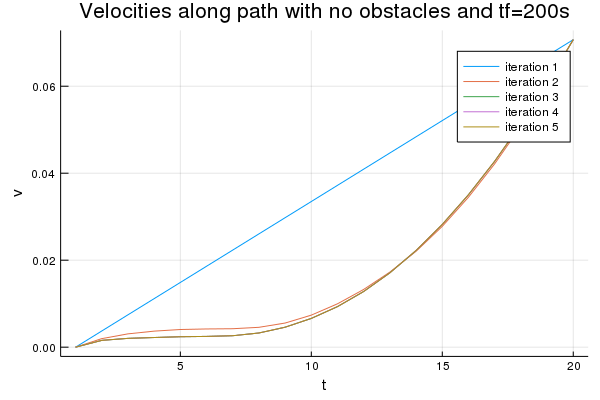

In [17]:
plotVelocities(traj_X_vec)
title!("Velocities along path with no obstacles and tf=200s")

## tf = 50 s

In [20]:
env = setUpEnvironmentNoObstacle()
N = 20
x_init = [0.2; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess=50);
traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]
# Solve one step at a time with IPOPT
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
iterCount = 1
max_iter = 30
while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
    solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
    if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = iterCount + 1
        @show iterCount
    end
end

iterCount = 2
iterCount = 3


(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK]


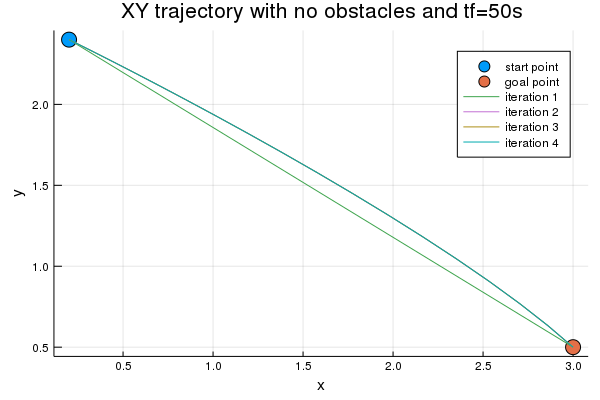

In [21]:
@show TOSgusto.SCPS.scp_status
plotXYTrajectories(traj_X_vec)
title!("XY trajectory with no obstacles and tf=50s")

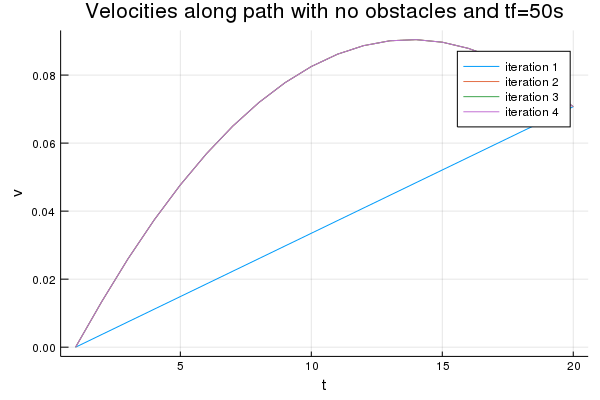

In [22]:
plotVelocities(traj_X_vec)
title!("Velocities along path with no obstacles and tf=50s")

## tf = 400 s

In [23]:
env = setUpEnvironmentNoObstacle()
N = 20
x_init = [0.2; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess=400);
traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]
# Solve one step at a time with IPOPT
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
iterCount = 1
max_iter = 30
while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
    solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
    if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = iterCount + 1
        @show iterCount
    end
end

iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5


(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :ViolatesConstraints, :OK, :OK, :OK]


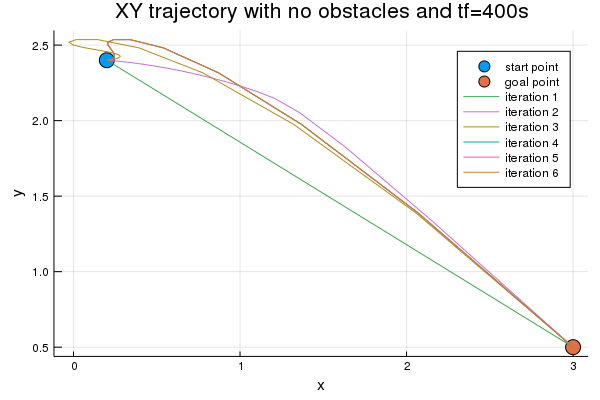

In [24]:
@show TOSgusto.SCPS.scp_status
plotXYTrajectories(traj_X_vec)
title!("XY trajectory with no obstacles and tf=400s")

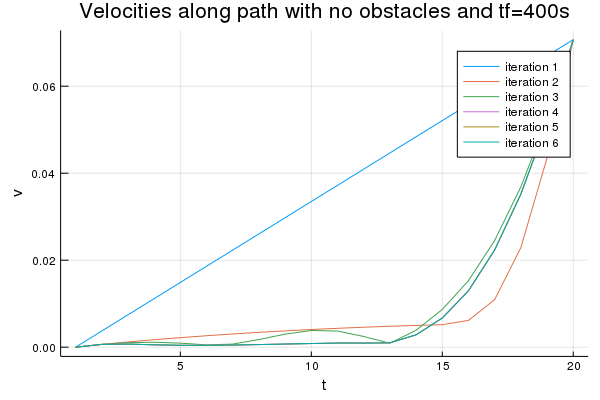

In [25]:
plotVelocities(traj_X_vec)
title!("Velocities along path with no obstacles and tf=400s")

# Plot trajectories from GuSTO for ONE obstacle

## tf = 200s

In [26]:
xObs = 1.500; yObs = 1.500; width = 0.1
env = setUpEnvironmentSingleObstacle(xObs, yObs, width)
N = 20
x_init = [0.2; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess=200);
traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]
# Solve one step at a time with IPOPT
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
iterCount = 1
max_iter = 30
while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
    solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
    if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = iterCount + 1
        @show iterCount
    end
end

iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6


(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :ViolatesConstraints, :OK, :OK, :OK, :OK]


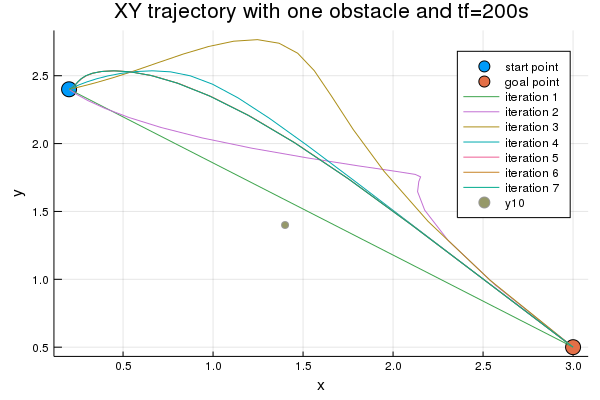

In [27]:
@show TOSgusto.SCPS.scp_status
plotXYTrajectories(traj_X_vec)
title!("XY trajectory with one obstacle and tf=200s")
xObs = env.obstacle_set[1].origin[1]
yObs = env.obstacle_set[1].origin[2]
widthObs = env.obstacle_set[1].widths[1]
scatter!([xObs],[yObs],marker=2*widthObs)


In [28]:
@show env.obstacle_set[1].origin
@show env.obstacle_set[1].widths


(env.obstacle_set[1]).origin = Float32[1.4, 1.4, -0.0635]
(env.obstacle_set[1]).widths = Float32[0.2, 0.2, 0.227]


3-element Vec{3,Float32}:
 0.2  
 0.2  
 0.227

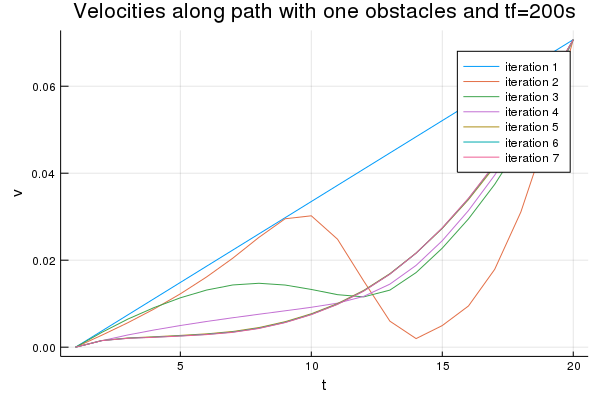

In [29]:
plotVelocities(traj_X_vec)
title!("Velocities along path with one obstacles and tf=200s")

In [30]:
            @show TOSgusto.SCPS.scp_status
            @show TOSgusto.SCPS.solver_status
            @show TOSgusto.SCPS.accept_solution
            @show TOSgusto.SCPS.param.alg.ω_vec

(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :ViolatesConstraints, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
(TOSgusto.SCPS).accept_solution = Bool[true, true, true, true, true, true, true]
(((TOSgusto.SCPS).param).alg).ω_vec = [1.0, 1.0, 10.0, 10.0, 10.0, 10.0, 10.0]


7-element Array{Float64,1}:
  1.0
  1.0
 10.0
 10.0
 10.0
 10.0
 10.0

# Only train on no obstacle environments, keep only first 3 iterations, check that final solution in 3 iterations is OK and converges, with Thomas's suggestions, also store 1st iteration separately

In [40]:
# Generate training data
# Keep environment constant and goal constant 
env = setUpEnvironmentNoObstacle()
N = 20
x_goal = [3.; 0.5; 0; 0; 0; 0]
num_problems = 1000
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8 
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)
# @show xVals
# @show yVals

max_iter = 2

train_input_collected_first_only = Array{Float64}(undef,0,182)
train_output_collected_first_only = Array{Float64}(undef,0,180)

train_input_collected = Array{Float64}(undef,0,182)
train_output_collected = Array{Float64}(undef,0,180)

problemNumber = 1
for xVal in xVals
    for yVal in yVals
        println("")
        @show problemNumber
        x_init = [xVal; yVal; 0; 0; 0; 0] 
#         @show x_init
        TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
        traj_init = init_traj_straightline(TOP)
        traj_X_vec = [traj_init.X]
        traj_U_vec = [traj_init.U]
        traj_X_vec_first_only = [traj_init.X]
        traj_U_vec_first_only = [traj_init.U]
        # Solve one step at a time with IPOPT
        solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        push!(traj_X_vec_first_only, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec_first_only, TOSgusto.SCPS.traj.U)
        iterCount = 1
        
        while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
            solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#             @show TOSgusto.SCPS.scp_status
#             @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
#             @show TOSgusto.SCPS.solver_status[end]
            if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED 
                push!(traj_X_vec, TOSgusto.SCPS.traj.X)
                push!(traj_U_vec, TOSgusto.SCPS.traj.U)
                iterCount = iterCount + 1
                @show iterCount
            end
        end
        if TOSgusto.SCPS.scp_status[end] == :OK 
            if TOSgusto.SCPS.converged
                println("Saving data solution converged and is OK")
                train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
                train_input_first_only, train_output_first_only = createTrainingInputAndOutput(traj_X_vec_first_only, traj_U_vec_first_only, TOSgusto.SCPS.param.alg.ω_vec[1:2], TOSgusto.SCPS.param.alg.Δ_vec[1:2])
        #         @show size(train_input)
        #         @show size(train_output)
                train_input_collected = vcat(train_input_collected, train_input)
                train_output_collected = vcat(train_output_collected, train_output)
                train_input_collected_first_only = vcat(train_input_collected_first_only, train_input_first_only)
                train_output_collected_first_only = vcat(train_output_collected_first_only, train_output_first_only)
            else
                println("solution is ok but DID NOT converge")
            end
        else
            @show TOSgusto.SCPS.scp_status
            println("solution DID NOT end in OK")
            if TOSgusto.SCPS.converged
                println("solution converged")
            else
                println("solution DID NOT converge")
            end
        end

        problemNumber = problemNumber + 1
        @save "NoObstacleFirst3IterEndsInOKtf80ZeroFinVel.jld2" train_input_collected train_output_collected
        @save "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1Iter.jld2" train_input_collected_first_only train_output_collected_first_only
    end
end


problemNumber = 1
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 2
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 3
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 4
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 5
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 6
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 7
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 8
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 9
iterCount = 2
iterCount = 3
(TOSgusto.S

# Only train on no obstacle environments and keep only first 2 iterations

In [34]:
# Generate training data
# Keep environment constant and goal constant 
env = setUpEnvironmentNoObstacle()
N = 20
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
num_problems = 1000
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8 
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)
# @show xVals
# @show yVals

max_iter = 2

train_input_collected = Array{Float64}(undef,0,182)
train_output_collected = Array{Float64}(undef,0,180)

problemNumber = 1
for xVal in xVals
    for yVal in yVals
        println("")
        @show problemNumber
        x_init = [xVal; yVal; 0; 0; 0; 0] 
#         @show x_init
        TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 50);
        traj_init = init_traj_straightline(TOP)
        traj_X_vec = [traj_init.X]
        traj_U_vec = [traj_init.U]
        # Solve one step at a time with IPOPT
        solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = 1
        
        while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
            solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#             @show TOSgusto.SCPS.scp_status
#             @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
            if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
                push!(traj_X_vec, TOSgusto.SCPS.traj.X)
                push!(traj_U_vec, TOSgusto.SCPS.traj.U)
                iterCount = iterCount + 1
                @show iterCount
            end
        end
        @show size(traj_X_vec)
        @show size(traj_X_vec[1])
        @show size(traj_U_vec[1])
        train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
        @show size(train_input)
        @show size(train_output)
        train_input_collected = vcat(train_input_collected, train_input)
        train_output_collected = vcat(train_output_collected, train_output)
        problemNumber = problemNumber + 1
        @save "NoObstacleFirst3Iter.jld2" train_input_collected train_output_collected
    end
end


problemNumber = 1
iterCount = 2
iterCount = 3
size(traj_X_vec) = (4,)
size(traj_X_vec[1]) = (6, 20)
size(traj_U_vec[1]) = (3, 20)
size(ω_vec) = (4,)
size(X_row) = (4, 120)
size(train_input) = (3, 182)
size(train_output) = (3, 180)

problemNumber = 2
iterCount = 2
iterCount = 3
size(traj_X_vec) = (4,)
size(traj_X_vec[1]) = (6, 20)
size(traj_U_vec[1]) = (3, 20)
size(ω_vec) = (4,)
size(X_row) = (4, 120)
size(train_input) = (3, 182)
size(train_output) = (3, 180)

problemNumber = 3
iterCount = 2
iterCount = 3
size(traj_X_vec) = (4,)
size(traj_X_vec[1]) = (6, 20)
size(traj_U_vec[1]) = (3, 20)
size(ω_vec) = (4,)
size(X_row) = (4, 120)
size(train_input) = (3, 182)
size(train_output) = (3, 180)

problemNumber = 4
iterCount = 2
iterCount = 3
size(traj_X_vec) = (4,)
size(traj_X_vec[1]) = (6, 20)
size(traj_U_vec[1]) = (3, 20)
size(ω_vec) = (4,)
size(X_row) = (4, 120)
size(train_input) = (3, 182)
size(train_output) = (3, 180)

problemNumber = 5
iterCount = 2
iterCount = 3
size(traj_X_vec) = (4,)
s

InterruptException: InterruptException:

# Only train on single obstacle environments and keep only first 4 iterations

In [ ]:
# Generate training data
# Keep environment constant and goal constant 
env = setUpEnvironmentSingleObstacle()
N = 20
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
num_problems = 1000
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8 
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)
# @show xVals
# @show yVals

max_iter = 4

train_input_collected = Array{Float64}(undef,0,182)
train_output_collected = Array{Float64}(undef,0,180)

problemNumber = 1
for xVal in xVals
    for yVal in yVals
        println("")
        @show problemNumber
        x_init = [xVal; yVal; 0; 0; 0; 0] 
#         @show x_init
        TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 50);
        traj_init = init_traj_straightline(TOP)
        traj_X_vec = [traj_init.X]
        traj_U_vec = [traj_init.U]
        # Solve one step at a time with IPOPT
        solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = 1
        
        while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
            solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#             @show TOSgusto.SCPS.scp_status
#             @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
            if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
                push!(traj_X_vec, TOSgusto.SCPS.traj.X)
                push!(traj_U_vec, TOSgusto.SCPS.traj.U)
                iterCount = iterCount + 1
                @show iterCount
            end
        end
        train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
#         @show size(train_input)
#         @show size(train_output)
        train_input_collected = vcat(train_input_collected, train_input)
        train_output_collected = vcat(train_output_collected, train_output)
        problemNumber = problemNumber + 1
        @save "SingleObstacleFirst5Iter.jld2" train_input_collected train_output_collected
    end
end


problemNumber = 1

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

iterCount = 2
iterCount = 3

problemNumber = 2
iterCount = 2
iterCount = 3

problemNumber = 3
iterCount = 2
iterCount = 3

problemNumber = 4
iterCount = 2
iterCount = 3

problemNumber = 5
iterCount = 2
iterCount = 3

problemNumber = 6
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 7
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 8
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 9
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 10
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 11
iterCount = 2
iterCount = 3
iterCount = 4

problemN

iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 117
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 118
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 119
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 120
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 121
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 122
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 123
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 124
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 125
iterCount = 2
iterCount = 3

problemNumber = 126
iterCount = 2
iterCount = 3

problemNumber = 127
iterCount = 2
iterCount = 3

problemNumber = 128
iterCount = 2
iterCount = 3

problemNumber = 129
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 130
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 131

iterCount = 4
iterCount = 5

problemNumber = 234
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 235
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 236
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 237
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 238
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 239
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 240
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 241
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 242
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 243
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 244
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 245
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 246
iterCount = 2
iterCount = 3
iterCount = 4

iterCount = 4

problemNumber = 349
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 350
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 351
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 352
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 353
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 354
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 355
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 356
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 357
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 358
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 359
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 360
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 361
iterCount = 2
iterCount = 3
iterCount = 4

iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 462
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 463
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 464
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 465
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 466
iterCount = 2
iterCount = 3

problemNumber = 467
iterCount = 2
iterCount = 3

problemNumber = 468
iterCount = 2
iterCount = 3

problemNumber = 469
iterCount = 2
iterCount = 3

problemNumber = 470
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 471
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 472
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 473
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 474
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 475
iterCount = 2
iterCount = 3
iterCount = 4
iterCo

iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 578
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 579
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 580
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 581
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 582
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 583
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 584
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 585
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 586
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 587
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 588
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 589
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 590
iterCount = 2
iterCount = 3

problemNumber = 591
iterCount = 2
iterCount = 3

problemNumber = 592

iterCount = 3
iterCount = 4

problemNumber = 708
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 709
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 710
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 711
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 712
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 713
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 714
iterCount = 2
iterCount = 3

problemNumber = 715
iterCount = 2
iterCount = 3

problemNumber = 716
iterCount = 2
iterCount = 3

problemNumber = 717
iterCount = 2
iterCount = 3

problemNumber = 718
iterCount = 2
iterCount = 3

problemNumber = 719
iterCount = 2
iterCount = 3

problemNumber = 720
iterCount = 2
iterCount = 3

problemNumber = 721
iterCount = 2
iterCount = 3

problemNumber = 722
iterCount = 2
iterCount = 3

problemNumber = 723
iterCount = 2
iterCount = 3

problemNumber = 724


problemNumber = 859
iterCount = 2
iterCount = 3

problemNumber = 860
iterCount = 2
iterCount = 3

problemNumber = 861
iterCount = 2
iterCount = 3

problemNumber = 862
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 863
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 864
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 865
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 866
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 867
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 868
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 869
iterCount = 2
iterCount = 3

problemNumber = 870
iterCount = 2
iterCount = 3

problemNumber = 871
iterCount = 2
iterCount = 3

problemNumber = 872
iterCount = 2
iterCount = 3

problemNumber = 873
iterCount = 2
iterCount = 3

problemNumber = 874
iterCount = 2
iterCount = 3

problemNumber = 875
iterCount = 2
iterCount = 3

problemNumber = 876
iterCo

# Code for second batch of training data

In [ ]:
# Generate training data
# Keep environment constant and goal constant 
env = setUpEnvironment()
N = 20
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
num_problems = 1000
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8 
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)
# @show xVals
# @show yVals

max_iter = 30

train_input_collected = Array{Float64}(undef,0,182)
train_output_collected = Array{Float64}(undef,0,180)

problemNumber = 1
for xVal in xVals
    for yVal in yVals
        println("")
        @show problemNumber
        x_init = [xVal; yVal; 0; 0; 0; 0] 
#         @show x_init
        TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
        traj_init = init_traj_straightline(TOP)
        traj_X_vec = [traj_init.X]
        traj_U_vec = [traj_init.U]
        # Solve one step at a time with IPOPT
        solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = 1
        
        while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
            solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#             @show TOSgusto.SCPS.scp_status
#             @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
            if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
                push!(traj_X_vec, TOSgusto.SCPS.traj.X)
                push!(traj_U_vec, TOSgusto.SCPS.traj.U)
                iterCount = iterCount + 1
                @show iterCount
            end
        end
        train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
#         @show size(train_input)
#         @show size(train_output)
        train_input_collected = vcat(train_input_collected, train_input)
        train_output_collected = vcat(train_output_collected, train_output)
        problemNumber = problemNumber + 1
        @save "secondBatch.jld2" train_input_collected train_output_collected
    end
end

# @save "firstBatch.jld2" train_input_collected train_output_collected


# Code for first batch of training data

In [ ]:
# Generate training data
# Keep environment constant and goal constant 
env = setUpEnvironment()
N = 20
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
num_problems = 100
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8 
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)
# @show xVals
# @show yVals

max_iter = 30

train_input_collected = Array{Float64}(undef,0,182)
train_output_collected = Array{Float64}(undef,0,180)

problemNumber = 1
for xVal in xVals
    for yVal in yVals
        println("")
        @show problemNumber
        x_init = [xVal; yVal; 0; 0; 0; 0] 
        @show x_init
        TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
        traj_init = init_traj_straightline(TOP)
        traj_X_vec = [traj_init.X]
        traj_U_vec = [traj_init.U]
        # Solve one step at a time with IPOPT
        solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = 1
        
        while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
            solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
            @show TOSgusto.SCPS.scp_status
            @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
            if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
                push!(traj_X_vec, TOSgusto.SCPS.traj.X)
                push!(traj_U_vec, TOSgusto.SCPS.traj.U)
                iterCount = iterCount + 1
                @show iterCount
            end
        end
        train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
        @show size(train_input)
        @show size(train_output)
        train_input_collected = vcat(train_input_collected, train_input)
        train_output_collected = vcat(train_output_collected, train_output)
        problemNumber = problemNumber + 1
        @save "firstBatch.jld2" train_input_collected train_output_collected
    end
end

# @save "firstBatch.jld2" train_input_collected train_output_collected


In [ ]:
# Violates constraints start point
env = setUpEnvironment()
N = 20
x_init = [0.6; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
# Solve full solution with IPOPT
full_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", max_iter=100, print_level=0);


In [ ]:
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec

In [ ]:
# Violates constraints start point
env = setUpEnvironment()
N = 20
x_init = [0.6; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);

traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]
# Solve one step at a time with IPOPT
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
iterCount = 1

while !TOSgusto.SCPS.converged && iterCount <=50
    solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
    push!(traj_X_vec, TOSgusto.SCPS.traj.X)
    push!(traj_U_vec, TOSgusto.SCPS.traj.U)
    iterCount = iterCount + 1
    @show iterCount 
#     @show TOSgusto.SCPS.param.alg.ω_vec
#     @show TOSgusto.SCPS.param.alg.Δ_vec
end
println("Finished!")
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show size(traj_X_vec)



In [ ]:
train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
@show size(train_input)
@show size(train_output)


In [ ]:
traj_X_vec_3d=cat(traj_X_vec...,dims=3)
@show size(traj_X_vec_3d)

using JLD2, FileIO
hello = "world"
foo = :bar
@save "example.jld2" hello foo

In [ ]:
# OK start point
env = setUpEnvironment()
N = 20
x_init = [0.2; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
# Solve full solution with IPOPT
full_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", max_iter=100, print_level=0);


In [ ]:
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec

In [ ]:
plotVelocity(TOSgusto.SCPS.traj.X, N)
plotXYTrajectory(TOSgusto.SCPS.traj.X)

In [ ]:
visualizeTraj(env, TOSgusto)

In [ ]:
# Solve full solution with Gurobi
env = setUpEnvironment()
N = 20
x_init = [0.4; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
full_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Gurobi", max_iter=100, OutputFlag=0);
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.accept_solution
# visualizeTraj(env, TOSgusto)

In [ ]:
# Create loop to run SCP one iteration at a time and store off TOSgusto.SCPS.traj as well as parameters
first_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", max_iter=1, print_level=0);
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show TOSgusto.SCPS.traj.X
@show TOSgusto.SCPS.traj.U
@show TOSgusto.SCPS.traj.Tf
@show TOSgusto.SCPS.traj.dt
@show TOSgusto.SCPS.iterations


# @show TOSgusto.SCPS.converged
# @show TOSgusto.SCPS.dual


In [ ]:
second_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show TOSgusto.SCPS.traj.X
@show TOSgusto.SCPS.traj.U
@show TOSgusto.SCPS.traj.Tf
@show TOSgusto.SCPS.traj.dt
@show TOSgusto.SCPS.iterations


In [ ]:
for i in 1:20
    next_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
    @show TOSgusto.SCPS.scp_status
    @show TOSgusto.SCPS.param.alg.ω_vec
    @show TOSgusto.SCPS.param.alg.Δ_vec
    @show TOSgusto.SCPS.traj.X
    @show TOSgusto.SCPS.traj.U
    @show TOSgusto.SCPS.traj.Tf
    @show TOSgusto.SCPS.traj.dt
    @show TOSgusto.SCPS.iterations
end

In [ ]:
full_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=100, print_level=0);
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show TOSgusto.SCPS.traj.X
@show TOSgusto.SCPS.traj.U
@show TOSgusto.SCPS.traj.Tf
@show TOSgusto.SCPS.traj.dt
@show TOSgusto.SCPS.iterations

In [ ]:
include("../ok.jl")

In [ ]:
# @show TOSgusto.SCPS.param.alg.ω_vec
function ok()
    print("thiss2")
end
ok()

In [ ]:
SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
@show TOSgusto.SCPS.dual
@show TOSgusto.SCPS.traj
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec

In [ ]:
using Profile
using ProfileView 
env = setUpEnvironment()
N = 20
x_init = [0.6; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
Profile.clear()
@profile solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Gurobi", OutputFlag=0)
ProfileView.view()

In [ ]:
using Profile
using ProfileView 
env = setUpEnvironment()
N = 20
x_init = [0.6; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
Profile.clear()
@profile solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", print_level=0)
ProfileView.view()

In [ ]:
SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Gurobi", OutputFlag=0);
# SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", print_level=0);


In [ ]:
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.total_time
@show TOSgusto.SCPS.accept_solution
@show TOSgusto.SCPS.solver_status
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.convergence_measure
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show TOSgusto.SCPS.J_true
@show TOSgusto.SCPS.dual
;

In [ ]:
@show TOSgusto.SCPS.traj


In [ ]:
typeof(TOSgusto.SCPS.traj)


In [ ]:
# Old version of code
# # Violates constraints start point
# env = setUpEnvironment()
# N = 20
# x_init = [0.6; 2.4; 0; 0; 0; 0]
# x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
# TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
# if isdefined(TOSgusto, :SCPS)
#     println("Before first, TOSgusto.SCPS defined")
# else
#     println("Before first, TOSgusto.SCPS NOT defined")
# end
# # Solve one step at a time with IPOPT
# solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", max_iter=1, print_level=0);
# # @show typeof(TOSgusto.SCPS.SCPP.param.alg)
# iterCount = 1
# if isdefined(TOSgusto.SCPS.param, :alg)
#     println("After first, TOSgusto.SCPS.param.alg defined")
# else
#     println("After first, TOSgusto.SCPS.param.alg NOT defined")
# end
# while !TOSgusto.SCPS.converged && iterCount <=15
#     solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#     iterCount = iterCount + 1
#     @show iterCount 
#     @show TOSgusto.SCPS.param.alg.ω_vec
#     @show TOSgusto.SCPS.param.alg.Δ_vec
# end
# println("Finished!")
# @show TOSgusto.SCPS.scp_status
# @show TOSgusto.SCPS.iterations
# @show TOSgusto.SCPS.converged
# @show TOSgusto.SCPS.param.alg.ω_vec
# @show TOSgusto.SCPS.param.alg.Δ_vec